Objective: To make a recommendation system that recommends at least five(5)
new products based on the user's habits

In [2]:
import numpy as np  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict
from surprise import SVD
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install surprise

In [4]:
ratings_data = pd.read_csv  ("/content/drive/MyDrive/ratings_Electronics.csv")
ratings_data.columns = ['user_id', 'product_id', 'ratings', 'timestamp']
ratings_data.head() 

,user_id,product_id,ratings,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


### There are four columns in the data
1. userId 
2. productId 
3. ratings 
4. timestamp (which will be removed as it's not required)

In [5]:
ratings_data.shape

(7824481, 4)

There are 7824481 rows.

In [6]:
# Let's drop timestamp column as it's not required in this case.
ratings_data.drop(axis=1, columns=['timestamp'], inplace=True)
ratings_data.head()

,user_id,product_id,ratings
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [7]:
ratings_data.dtypes

user_id        object
product_id     object
ratings       float64
dtype: object

- User_id and product_id are two object type data and ratings column contains floating values.

In [8]:
ratings_data.isnull().sum()

user_id       0
product_id    0
ratings       0
dtype: int64

- There are no missing values in the dataset

In [9]:
#No of unique customers and products
print("Unique Customers: ",ratings_data.user_id.nunique())
print("Unique Products: ",ratings_data.product_id.nunique())

Unique Customers:  4201696
Unique Products:  476001


In [10]:
#to view the five point summary
ratings_data.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,7824481.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


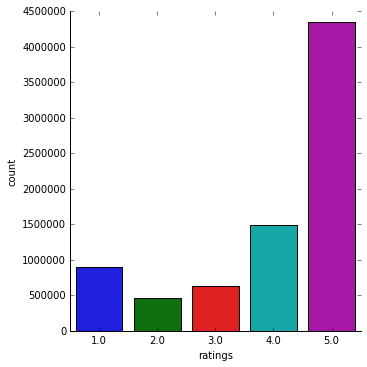

In [11]:
#sns.histplot(ratings_data['ratings'])
sns.catplot("ratings",data=ratings_data, kind='count')

Rating 5 is most common rating.

In [12]:
ratings=pd.DataFrame(ratings_data.groupby('product_id')['ratings'].mean())
ratings['rating_count']=pd.DataFrame(ratings_data.groupby('product_id')['ratings'].count())
ratings.head()

,ratings,rating_count
product_id,,
0321732944,5.000000,1
0439886341,1.666667,3
0511189877,4.500000,6
0528881469,2.851852,27
0558835155,3.000000,1


Text(0.5, 1.0, 'Distribution of Ratings')

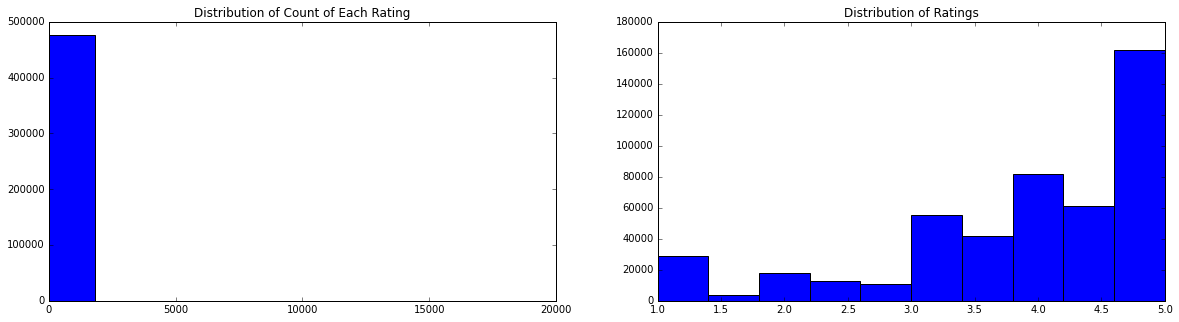

In [13]:
#Let's check the rating distribution across all the ratings.
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(ratings.rating_count)
plt.title('Distribution of Count of Each Rating')

plt.subplot(1,2,2)
plt.hist(ratings.ratings)
plt.title('Distribution of Ratings')

## Subsetting of data:
  Let's keep the users only who has given 50 or more number of ratings

In [14]:
subset = ratings_data.user_id.value_counts()
#subset[subset.values>=50].index.shape

In [15]:
subset_data = ratings_data[ratings_data['user_id'].isin(subset[subset>=50].index)]

In [16]:
subset_data.shape

(125871, 3)

- We are going to use subset of data of the original dataser with 125871 rows.

# Popularity Based Recommendation System

In [17]:
## Product wise average ratings

In [18]:
subset_data.groupby('product_id')['ratings'].mean().head()

product_id
0594451647    5.000000
0594481813    3.000000
0970407998    2.500000
0972683275    4.750000
1400501466    3.333333
Name: ratings, dtype: float64

- This give us the product wise average rating.

In [19]:
subset_data.groupby('product_id')['ratings'].mean().sort_values(ascending=False).head()

product_id
B00LKG1MC8    5.0
B002QUZM3M    5.0
B002QWNZHU    5.0
B002QXZPFE    5.0
B002R0DWNS    5.0
Name: ratings, dtype: float64

- This gives us average rating in descending order, above list shows 5 products. This doesn't tell us how many ratings recieved by each of the product.

In [20]:
subset_data.groupby('product_id')['ratings'].count().sort_values(ascending=False).head() 

product_id
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
Name: ratings, dtype: int64

- This gives us the list of products with number of ratings recieved in descending order. For example the product with ID B0074BW614 rated 18244 times, highest in the list. This tells us that every product might have different count of total ratings recieved bu users.

In [21]:
# Let's create prodcut wise ratings mean count and add it ina data frame
ratings_mean_count = pd.DataFrame(subset_data.groupby('product_id')['ratings'].mean())

In [22]:
# let's add new column ratings_count in ratings_mean_count dataframe
ratings_mean_count['rating_counts'] = pd.DataFrame(subset_data.groupby('product_id')['ratings'].count())

In [23]:
# Let's print first 5 lines of the dataframe
ratings_mean_count.head()

,ratings,rating_counts
product_id,,
0594451647,5.000000,1
0594481813,3.000000,1
0970407998,2.500000,2
0972683275,4.750000,4
1400501466,3.333333,6


- This gives us the list of products with average rating and total count. Based on ratings the product with id 0321732944 has recieved highest rating i.e. 5 but it has rated by only one user. 
-The biggest disadvantage of Popularity based on recommendation system is it's not personalized as we just consider average rating and rating count.

Text(0.5, 1.0, 'Distribution of Ratings')

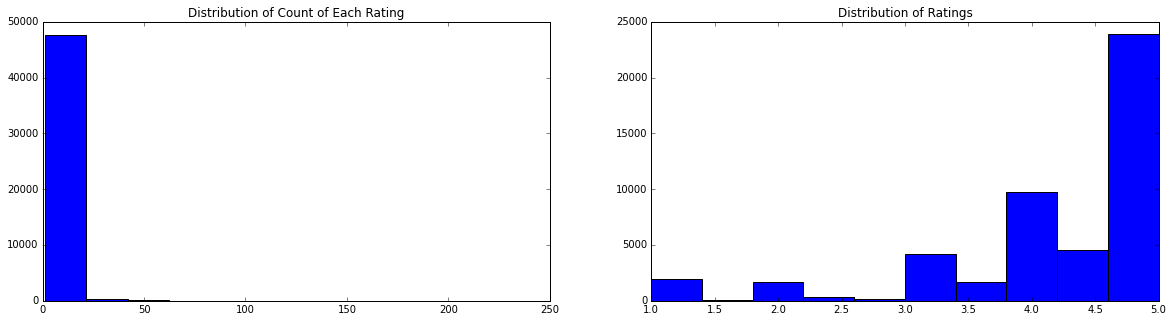

In [24]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(ratings_mean_count.rating_counts)
plt.title('Distribution of Count of Each Rating')

plt.subplot(1,2,2)
plt.hist(ratings_mean_count.ratings)
plt.title('Distribution of Ratings')

- Distibution of ratings looks better compared to distribution across complete dataset.

In [25]:
#ratings_mean_count.to_csv('/content/drive/MyDrive/popularity.csv')
popularity_recommender_df = ratings_mean_count.sort_values(by=['ratings','rating_counts'], ascending=False)
popularity_recommender_df.head()

,ratings,rating_counts
product_id,,
B000FQ2JLW,5.0,19
B00ISFNSBW,5.0,18
B000IJY8DS,5.0,17
B001TH7GUA,5.0,17
B00HZWJGS8,5.0,17


- This give us top 5 recommendations based on average user rating score and total number of ratings recieved for a product.

In [26]:
popularity_recommender_rating_count = ratings_mean_count.sort_values(by=['rating_counts','ratings'], ascending=False)
popularity_recommender_rating_count.head()

,ratings,rating_counts
product_id,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149


- This give us the top-5 recommendations considering rating_counts as additonal parameter to give better recommendations.

# Collaborative Filtering model:

In [27]:
# Let's split the data into train and test data in 70:30 proportion
subset_data.reset_index()
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(subset_data[['user_id', 'product_id', 'ratings']], reader)
trainset, testset = train_test_split(data, test_size=0.30)

1. User-based collaborative filtering

In [28]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [29]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [30]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [31]:
# Print the recommended items for each user
top_n = get_top_n(test_pred, n=5)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A1YEPFLLH42OU1 ['B002YU83YO', 'B006TT91TW', 'B0052SCU8U', 'B00D9TBDDM', 'B008HK3QII']
A12EVK82QUTSA6 ['B002ZCXJZE', 'B001CCLBSA', 'B00829TIEK', 'B002K9IHGI', 'B002ZDJSRQ']
A35HNL2VEDK9Z1 ['B00829THK0', 'B000BTCJNG', 'B009B0MZ8U', 'B00AJHDZSI', 'B00005LEOH']
A2SPV96SGOEO2 ['B00EOYSH94', 'B00834SJSK', 'B00CI3BIWQ', 'B007Q8GOGI', 'B000N99BBC']
AY3XPKRAMKKY7 ['B004TLH7C0', 'B0007R4LI8', 'B00832NCWU', 'B001L9O73U', 'B000NB05MO']
A11KZ906QD08C5 ['B001TH7GSW', 'B000P1O73A', 'B00FEE7B1I', 'B00IVFDZBC', 'B001VFUN82']
A1MFPAM9TTRTXN ['B003ES5ZUU', 'B001TQ2PSO', 'B000HZGQ9C', 'B00DY3J8VM', 'B00B4GGW5Q']
A5MCDQ60DWUEV ['B008EQYRRY', 'B003Q9RERY', 'B002K3Z3E8', 'B00004THCZ', 'B001G445Q4']
A3IJ4Z18FTIIP ['B009NB8WR0', 'B000F3W9YC', 'B001U3Y8Q8', 'B0012YJQWQ', 'B0000E6RVW']
A2DKQQIZ793AV5 ['B006OBGEHW', 'B00FIYDC1W', 'B00F9FCW7K', 'B00CEZBKTO', 'B00A39PPCG']
A32NEDX6UVV8DE ['B00829TIA4', 'B000LRMS66', 'B005D91G38', 'B007BXD6DW', 'B009KPARMC']
ABXANRX4GPYRZ ['B002C7481G', 'B00B5IQ3TI', 'B000FEKEN4', '

- This gives us the list of recommended products to each user based on his/her habits

In [32]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.0645


1.0645239937345279

In [33]:
accuracy.mae(test_pred, verbose=True)

MAE:  0.7840


0.7839564334094398

In [34]:
results=pd.DataFrame({'USER_USER_CF':[1.741, 0.781]}, index=['RMSE', 'MSE'])
results

,USER_USER_CF
RMSE,1.741
MSE,0.781


3. Item-Item Collaborative Filtering

In [ ]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...


In [ ]:
predictions_item_based = algo.test(testset)
accuracy.rmse(predictions_item_based)

In [ ]:
accuracy.mse(predictions_item_based)

Top-5 recommendations based on Item-Item Colloborative Filtering

In [ ]:
top_n = get_top_n(predictions_item_based, n=5)

In [ ]:
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

2. Collaborative Filtering using SVD

In [ ]:
algo = SVD()
algo.fit(trainset)

In [ ]:
predictions = algo.test(testset)
accuracy.rmse(predictions)

In [ ]:
accuracy.mse(predictions)

In [ ]:
top_n = get_top_n(predictions, n=5)

In [ ]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

- This gives us the list of recommended products to each user based on his/her habits

In [ ]:
#results=pd.DataFrame({'SVD':[1.741]}, index=['RMSE'])
results['SVD'] = [0.9823, 0.9648]
results

# Conclusion:
**Popularity Recommendation System:** We can see that the recommendations 

for each user is top five average ratings, which doesn't take users buying habits into considerations. However these recommendations will really help in case there is a new user in the system.

**Collaborative Filtering:**

As our goal is to recommend new products to each user based on his/her habits, we have recommend 5 new products. We created two different models using User-User colloberative filtering and SVD.

SVD model has provided better recommendations based on the model score 0.982 compared to RMSE score 1.741 in case of USER-USER colloborative filtering.
